# Part A: Classification Problem

* **Name** Acharya Atul
* **Matriculation Number** U1923502C
* **Email** atul001@e.ntu.edu.sg

# Question 2
>In this question, we will determine the optimal batch size for mini-batch gradient descent. Find
the optimal batch size for mini-batch gradient descent by training the neural network and
evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on
training partition to perform hyperparameter selection. <br><br>
You will have to reconsider the scaling of the dataset during the 5-fold cross validation

### Install latest version of tensorflow

In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator

### Neccessary Imports

* **pandas** - Data analysis and manipulation
* **matplotlib** - Plotting graphs and creating visuals
* **sklearn** - Basic data preprocessing, splitting dataset and cross validation
* **tensorflow** - Modeling neural networks and training them

In [2]:
import time

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2022-10-10 06:25:31.634111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 06:25:31.801662: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-10 06:25:32.676559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local

### Setting the seed for reproducability

>For this assignment we will be using 42 as the seed

In [3]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

### Reading dataset

In [4]:
df = pd.read_csv('../input/assignment/full.csv')
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [5]:
df['label'] = df['filename'].str.split('_').str[-2]

In [6]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

### Function to preprocess the dataset and split it into train and test

In [7]:
def split_dataset(df, columns_to_drop, test_size, random_state):
    label_encoder = preprocessing.LabelEncoder()

    df['label'] = label_encoder.fit_transform(df['label'])

    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

    df_train2 = df_train.drop(columns_to_drop,axis=1)
    y_train2 = df_train['label'].to_numpy()

    df_test2 = df_test.drop(columns_to_drop,axis=1)
    y_test2 = df_test['label'].to_numpy() 

    return df_train2, y_train2, df_test2, y_test2

### Function to appropriately scale the dataset

In [8]:
def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)

    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

### Preprocess and scale the dataset

In [9]:
columns_to_drop = ['label','filename']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

### Set variables for training
* **Number of epochs**: 50
* **Number of folds**: 5
* **Search space of batch size**: [ 128, 256, 512, 1024 [](http://)]

In [10]:
num_epochs = 100

num_folds = 5

batch_sizes = [128, 256, 512, 1024]

### Callback to record the training time on the last epoch

> The class inhherits from ***tf.keras.callbacks.Callback*** and implements the following methods: <br>
***on_epoch_begin***: Calculates the time at which the epoch starts <br>
***on_epoch_end***: Calculates the time at which the epoch ended <br>
***on_train_end***: Calculates the differnce between the end time and start time at the end of the last epoch.

In [11]:
class TimerCallback(tf.keras.callbacks.Callback):
    def __init__(self) -> None:
        super().__init__()
        self.time_taken_in_last_epoch = 0
        self.start_time = 0
        self.end_time = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.end_time = time.time()
    
    def on_train_end(self, logs=None):
        self.time_taken_in_last_epoch = self.end_time - self.start_time

### Create model architecture based on specifications

In [12]:
def create_model(input_shape):
    
    # Number of neurons in every hidden layer
    num_neurons = 128
    
    model = Sequential([
        InputLayer(input_shape=(input_shape,)),
        Dense(num_neurons, activation='relu'),
        Dropout(0.2),
        Dense(num_neurons, activation='relu'),
        Dropout(0.2),
        Dense(num_neurons, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)

    model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    
    return model

## Part A
>Plot mean cross-validation accuracies on the final epoch for different batch sizes as
a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. This might take
a while to run.

### Hyperparamter tuning with 5-Fold Cross Validation
> For each batch size we perform a 5-Fold cross validation and report the mean validation accuracy. In my experiment, I have chosen the outer loop to iterate through the batch size space and the inner loop performs the 5-Fold Cross Validation. I wanted each batch size to be its own experiment. Note that you can reverse the loop order and train for each batch size on the same fold. Since I am using a seed, the cross validation split should be the same and both methods must give the same answer.

> **Scaling** <br>
The scaling is performed in the Cross Validation loop and the scalar is fit only on the training fold and not the validation fold. This is done to prevent data leakage and it does not include the validation set when calculating the statistics for the training set.

In [13]:
input_shape = X_train.shape[1]

batch_size_acc = {}
timer = {}

for batch_size in batch_sizes:
    fold = 0
    acc = []
    cv = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    timer[batch_size] = 0

    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_copy, y_train_copy  = X_train.iloc[train_idx], y_train[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        X_train_copy_scaled, X_val_scaled = preprocess_dataset(X_train_copy, X_val)
        
        model = create_model(input_shape)

        timer_callback = TimerCallback()
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
            
        history = model.fit(X_train_copy_scaled, y_train_copy,
                            epochs=num_epochs,
                            verbose=0,
                            batch_size=batch_size,
                            use_multiprocessing=False,
                            validation_data=(X_val_scaled, y_val),
                            callbacks=[timer_callback, early_stopping_callback] 
                        )
        

        timer[batch_size] += timer_callback.time_taken_in_last_epoch
        
        acc.append(history.history['val_accuracy'][-1])
        
        print(f'Batch Size {batch_size} | fold {fold} | validation accuracy {acc[fold]} | Time on last epoch {timer_callback.time_taken_in_last_epoch}')
        fold += 1
    
    timer[batch_size] /= num_folds
        
    print('* mean accuracy = %g *'% np.mean(acc))
    batch_size_acc[batch_size] = np.mean(acc)

2022-10-10 06:25:42.508671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 06:25:42.610415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 06:25:42.611276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 06:25:42.612380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Batch Size 128 | fold 0 | validation accuracy 0.6481423377990723 | Time on last epoch 2.6391024589538574
Batch Size 128 | fold 1 | validation accuracy 0.6440664529800415 | Time on last epoch 3.0073776245117188
Batch Size 128 | fold 2 | validation accuracy 0.6553791761398315 | Time on last epoch 2.652071714401245
Batch Size 128 | fold 3 | validation accuracy 0.6533019542694092 | Time on last epoch 2.3335835933685303
Batch Size 128 | fold 4 | validation accuracy 0.642524003982544 | Time on last epoch 2.3572163581848145
* mean accuracy = 0.648683 *
Batch Size 256 | fold 0 | validation accuracy 0.6568427681922913 | Time on last epoch 1.1644675731658936
Batch Size 256 | fold 1 | validation accuracy 0.6598604917526245 | Time on last epoch 1.32035231590271
Batch Size 256 | fold 2 | validation accuracy 0.6460121273994446 | Time on last epoch 1.513153076171875
Batch Size 256 | fold 3 | validation accuracy 0.6570252776145935 | Time on last epoch 1.3174030780792236
Batch Size 256 | fold 4 | valid

### Scatter plot of mean cross-validation accuracies on the final epoch for different batch sizes 

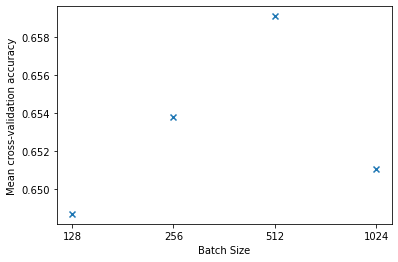

In [14]:
fig, ax = plt.subplots()
ax.scatter([str(batch_size) for batch_size in batch_size_acc.keys()], batch_size_acc.values(),  marker = 'x')
plt.xlabel('Batch Size')
plt.ylabel('Mean cross-validation accuracy')
plt.show()

### Observations
> The batch size that gives the best score is 512. At first the accuracy increases as the batch size increases and then the accuracy drops at batch size = 1024.

## Part B
>Create a table of time taken to train the network on the last epoch against
different batch sizes. (Hint: Introduce a callback)

### Table of time taken to train on the last epoch

In [15]:
timer_df = pd.DataFrame()
timer_df['batch_size'] = timer.keys()
timer_df['training_time_on_last_epoch'] = timer.values()
timer_df

,batch_size,training_time_on_last_epoch
0,128,2.597870
1,256,1.308935
2,512,0.660565
3,1024,0.365649


### Observations
> As the batch size increases, the training time decreased. This is because increasing batch size as it is equivalent to taking a few big steps, instead of taking many little steps.

## Part C
> Select the optimal batch size and state a reason for your selection

### Selection of optimal batch size
> To select the optimal batch size we need to analyze the tradeoff between accuracy and training time. Since the training time is still relatively small < 2s per epoch for every batch size, it is safe to ignore the training time for this question. Therefore, the selection of batch size is solely based on the mean cross validation accuracy.
<br>
**Optimal Batch Size = 512**

In [16]:
optimal_batch_size = max(batch_size_acc, key=batch_size_acc.get)
print(f'Optimal Batch Size: {optimal_batch_size}')

Optimal Batch Size: 512


## Part D
> What happens when batch size increases, and why does it happen? 

### Effects of increasing batch size
> ***Effect on training time***<br>
As we can see from the table in Question 2b, the training time reduces as the batch size increases. <br><br>If you hold the number of epochs constant, then the total number of gradient descent steps made by the algorithm is inversely proportional to the batch size. That's because to go through all of the data (one epoch), you need num_examples / batch_size steps. <br><br>As the batch size increases, there are more training examples to calculate the loss for. Moreover, there also needs to be more amount of computation in the forward prop. But however, most of this is optimized using **Vectorization** (Array programming, a style of computer programming where operations are applied to whole arrays instead of individual elements).<br><br>
***Effect on accuracy***<br>
From the scatter plot its difficult to make a solid claim about the effect of batch size. Different runs with different seeds gave different results.<br><br>
Gradients with small batch size oscillates much more compared to larger batch size. This oscillation can be considered noise and helps the model escape local minima. Larger batches do fewer and coarser search steps for the optimal solution, and so by construction will be less likely to converge on the optimal solution. This should mean that decreasing the batch size improves the accuracy/loss <br><br> However from the scatter plot, we can see that the accuracy improves as the batch size increases and peaks at Batch Size = 512. However, at Batch Size = 1024, there is a dip in accuracy. 


## Part E
>Plot the train and test accuracies against epochs for the optimal batch size in a line
plot. 

### Training model on entire training set with optimal batch size

In [17]:
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

model = create_model(input_shape)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
    
history = model.fit(X_train_scaled, y_train,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=optimal_batch_size,
                    use_multiprocessing=False,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping_callback] 
                )

Epoch 1/100
250/250 [==============================] - 2s 5ms/step - loss: 0.6910 - accuracy: 0.5355 - val_loss: 0.6857 - val_accuracy: 0.5479
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6842 - accuracy: 0.5502 - val_loss: 0.6826 - val_accuracy: 0.5537
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6815 - accuracy: 0.5562 - val_loss: 0.6812 - val_accuracy: 0.5581
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6790 - accuracy: 0.5624 - val_loss: 0.6784 - val_accuracy: 0.5661
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6768 - accuracy: 0.5667 - val_loss: 0.6758 - val_accuracy: 0.5694
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6739 - accuracy: 0.5720 - val_loss: 0.6739 - val_accuracy: 0.5753
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6709 - accuracy: 0.5778 - val_loss: 0.6704 - val_accuracy: 0.5804

## Plot of train and test accuracies

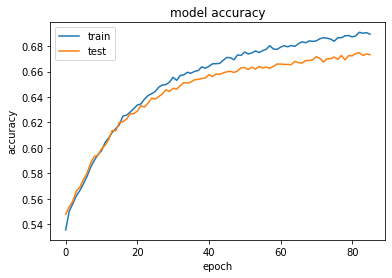

In [18]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Plot of train and test losses

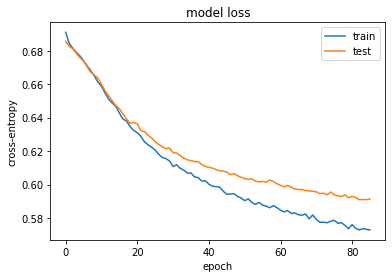

In [19]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')